In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
import sys
import os

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")

In [3]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)
invalid_subjs = qa_records['invalid']

In [4]:
RESULTS_PATH = os.path.join(get_n_dir_up(CUR_PATH, 3), 'results')
PLOTS_FOLDER = os.path.join(RESULTS_PATH, 'images', 'oscillations')

## Load the prediction data

In [5]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

In [8]:
TRIAL_TIMEPOINT_PRED_PATH = os.path.join(
    RESULTS_PATH, 'stats', 'gaze', 'inverted_enc', 'predictions')

In [16]:
def deg_signed_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d

def compute_accuracy(distrib, T=180):
    # 0 --> err = 0
    # 0.5 --> max err
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.cos(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)
    acc = np.sum(distrib_vec * baseline_vec, axis=-1)
    return acc

def compute_bias(distrib, T=180, err_thresh=40):
    # 0 --> no bias
    # 0.25 --> most positive bias
    # 0.5 --> neutral?
    # 0.75 --> most negative bias
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.sin(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)

    # error filtering
    total_weights = np.linalg.norm(baseline_vec)
    if err_thresh is None:
        err_thresh = 180
    mask = np.abs(errs) <= (err_thresh * 360 / T)
    distrib_vec = distrib_vec[..., mask]
    baseline_vec = baseline_vec[mask]
    kept_weights = np.linalg.norm(baseline_vec)

    ratio = total_weights / kept_weights
    bias = np.sum(distrib_vec * baseline_vec, axis=-1) * ratio
    return bias

In [ ]:
def load_preds_timepoint(mode, phase_ids, lmb, align_type='target'):
    mode_path = os.path.join(TRIAL_TIMEPOINT_PRED_PATH, f'{mode}_delay_phase')
    df = pd.read_csv(os.path.join(mode_path, 'y_df.csv'), index_col=0)
    select_mask = lmb(df) if lmb is not None else np.ones(df.shape[0], dtype=bool)
    stim_masks = {
        'stim_1': select_mask.copy(),
        'stim_2': select_mask.copy(),
    }
    pred_accs = [[], []]
    for pid in phase_ids:
        for i, stim_id in enumerate(['stim_1', 'stim_2']):
            loaded = np.load(
                os.path.join(mode_path, f'phase_{pid}', 
                    'aligned', stim_id, f'{align_type}.npy'), 
                allow_pickle=True)
            # update mask and select
            load_valid_mask = (~(np.isnan(loaded[:, 0]))) & stim_masks[stim_id]
            stim_masks[stim_id] = stim_masks[stim_id] & load_valid_mask
            loaded = loaded[load_valid_mask]
            # compute trial wise accuracy and bias
            accs = compute_accuracy(loaded)
            pred_accs[i].append(accs)

    pred_accs = np.array(pred_accs)
    dfs = [df[stim_masks[stim_id]] for stim_id in ['stim_1', 'stim_2']]
    return dfs, pred_accs

In [14]:
DEFAULT_PHASE_IDS = np.arange(11).astype(int)

In [15]:
DRAW_TARGET_PREDICTION_RESULTS = load_preds_timepoint(
    'draw', DEFAULT_PHASE_IDS, draw_lmb, align_type='target')
CLICK_TARGET_PREDICTION_RESULTS = load_preds_timepoint(
    'click', DEFAULT_PHASE_IDS, click_lmb, align_type='target')

(1916,)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1916 but corresponding boolean dimension is 180

### Keep only trials that people do remember the result, and stim1 stim 2 differ enough

In [10]:
def angle_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d

In [11]:
MAX_BEHAV_ERR = 25
err1 = angle_diff(behavior_df['resp_1'].to_numpy() - behavior_df['stim_1'].to_numpy())
err2 = angle_diff(behavior_df['resp_2'].to_numpy() - behavior_df['stim_2'].to_numpy())
valid_mask = (np.abs(err1) < MAX_BEHAV_ERR) & (np.abs(err2) < MAX_BEHAV_ERR)

MIN_DIFF = 15
large_diff = angle_diff(behavior_df['stim_1'].to_numpy() - behavior_df['stim_2'].to_numpy())
valid_mask = valid_mask & (np.abs(large_diff) > MIN_DIFF)

In [12]:
predictions = predictions[valid_mask]
behavior_df = behavior_df[valid_mask]

## Compute the confidence for each target

In [13]:
import matplotlib.pyplot as plt

In [14]:
def angle_scaled_dist(d1, epoch=180):
    diffs = angle_diff(d1, epoch)
    abs_diffs = np.abs(diffs)
    scaled_diffs = abs_diffs / (epoch // 2)
    return scaled_diffs

In [15]:
def compute_target_dists(predictions, targets):
    # predictions: (n_samples, t, n_versions)
    # targets: (n_samples, n_targets)
    # compute the difference
    d1 = predictions[:, :, None, :] - targets[:, None, :, None] # n_sample x T x n_targets x n_versions
    dists = angle_scaled_dist(d1)
    dists = np.mean(dists, axis=-1) # take the average... (TODO:? or median?)

    return dists

def compute_target_confidence(target_dists, scale, noise_factor):
    # size: n_samples x T x n_targets
    n_samples, T, n_targets = target_dists.shape
    noise_pad = np.full((n_samples, T, 1), noise_factor)
    padded = np.concatenate([target_dists, noise_pad], axis=-1)
    # compute the weights
    rads = padded * np.pi / 2
    weights = np.exp(-np.sin(rads) * scale)
    confidence = weights / np.sum(weights, axis=-1, keepdims=True)
    confidence = confidence[..., :-1] # remove the noise
    return confidence

In [16]:
dists = compute_target_dists(predictions, behavior_df[['stim_1', 'stim_2']].values)
confs = compute_target_confidence(dists, scale=2, noise_factor=0.5)

(array([ 7001., 11092., 12989.,  7493.,  5669.,  5449.,  5778.,  5561.,
         4522.,  2081.]),
 array([0.10040144, 0.1621759 , 0.22395036, 0.28572481, 0.34749927,
        0.40927372, 0.47104818, 0.53282264, 0.59459709, 0.65637155,
        0.718146  ]),
 <BarContainer object of 10 artists>)

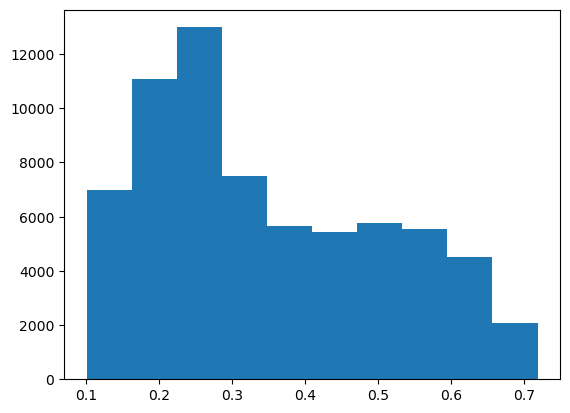

In [17]:
plt.hist(confs[..., 1].flatten())

## Oscillation analysis

In [18]:
test_time_path = os.path.join(result_folder, 'test_time.npy')
test_time_point = np.load(test_time_path)

In [19]:
test_times = np.mean(test_time_point, axis=1) / 1000

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.fftpack import fft, fftfreq
from scipy.signal import correlate

from sklearn.cluster import KMeans

def compute_states_transisiton(time, dominant_state,n_states):
    transition_counts = np.zeros((n_states, n_states)) 
    dwell_times = {k: [] for k in range(n_states)}

    # Compute transition counts and dwell times
    N_trials, T = dominant_state.shape
    dt = time[1] - time[0]
    for i in range(N_trials):
        prev_state = dominant_state[i, 0]
        dwell_time = 0
        
        for t in range(1, T):
            curr_state = dominant_state[i, t]
            if curr_state == prev_state:
                dwell_time += dt
            else:
                dwell_times[prev_state].append(dwell_time)  # Record dwell time
                transition_counts[int(prev_state),
                                  int(curr_state)] += 1
                prev_state = curr_state
                dwell_time = dt  # Reset dwell time

    # Normalize transition matrix
    transition_probs = transition_counts / np.sum(transition_counts, axis=1, keepdims=True)

    return transition_probs

def compute_fft_autocorr(time, conf1, conf2):
    T = len(time)
    dt = time[1] - time[0]
    freq = fftfreq(T, d=dt)[:T // 2]

    # Compute FFT and Autocorrelation for confidence signals
    mean_conf1 = np.mean(conf1, axis=0)
    mean_conf2 = np.mean(conf2, axis=0)
    mean_conf_delta = mean_conf1 - mean_conf2

    fft_delta = np.abs(fft(mean_conf_delta))[:T // 2]
    auto_corr_delta = correlate(mean_conf_delta - np.mean(mean_conf_delta), mean_conf_delta - np.mean(mean_conf_delta), mode='full')
    auto_corr_delta = auto_corr_delta[T - 1:]  # Keep only positive lags
    lags = np.arange(T) * dt

    return freq, fft_delta, lags, auto_corr_delta


def plot_state_plot(ax, states, n_states, state_colors):
    cmap = mcolors.ListedColormap(state_colors)
    bounds = np.arange(n_states+1) - 0.5
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    raster_data = states

    # sort the trials by 'patterns'
    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(raster_data)
    ## compute non-zero frequency per cluster
    cluster_frequencies = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_frequencies[i] = np.mean(raster_data[cluster_labels == i] > 0)
    sorted_cluster_indices = np.argsort(cluster_frequencies)  # Sort indices
    cluster_mapping = {old: new for new, old in enumerate(sorted_cluster_indices)}
    new_cluster_labels = np.array([cluster_mapping[label] for label in cluster_labels])
    ## reorder trials based on new cluster labels
    sorted_indices = np.argsort(new_cluster_labels)  # Sort trials by new cluster order
    raster_data = raster_data[sorted_indices]

    state_plot = ax.imshow(
        raster_data, aspect='auto', cmap=cmap, norm=norm, interpolation='nearest')
    ax.set_xlabel("Time")
    ax.set_ylabel("Trial")

    return state_plot

def plot_fft_autocorr(ax, freq, fft_delta):
    ax.plot(freq, fft_delta, 'k-')
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude")

def plot_latency_autocorr(ax, lags, auto_corr_delta):
    ax.plot(lags, auto_corr_delta)
    ax.set_xlabel("Time Lag")    
    ax.set_ylabel("Autocorrelation")

def summarize_oscillations_across_trials(time, conf_target1_trials, conf_target2_trials):
    # Compute dominant state per trial
    N_trials, T = conf_target1_trials.shape
    dominant_state = np.zeros((N_trials, T)).astype(int)  # Initialize with NaNs
    conf_thresh = 0.33
    mask_t1 = (conf_target1_trials > conf_thresh) & (conf_target1_trials > conf_target2_trials)
    mask_t2 = (conf_target2_trials > conf_thresh) & (conf_target2_trials > conf_target1_trials)
    dominant_state[mask_t1] = 1
    dominant_state[mask_t2] = 2

    # three state masks
    # - Nan, state 1, state 2
    # - Non-state 1, state 1
    # - Non-state 2, state 2
    statemap_titles = [
        'All states',
        'Target 1 v.s. Non Target 1',
        'Target 2 v.s. Non Target 2',
    ]
    all_state_names = [
        ['nan', 'target 1', 'target 2'],
        ['other', 'target 1'],
        ['other', 'target 2'],
    ]
    states_result = [
        dominant_state,
        (dominant_state == 1).astype(int),
        (dominant_state == 2).astype(int)
    ]
    state_conf_results = [
        (conf_target1_trials, conf_target2_trials),
        (conf_target1_trials, 1 - conf_target1_trials),
        (conf_target2_trials, 1 - conf_target2_trials),
    ]
    all_state_colors = [
        ['white', 'red', 'blue'],
        ['white', 'red'],
        ['white', 'blue'],
    ]

    fig, axs = plt.subplots(3, 2, figsize=(10, 9))
    for i in range(3):
        # number of states
        state_colors = all_state_colors[i]
        n_states = len(state_colors)

        statemap_title = statemap_titles[i]
        statemap = states_result[i]
        conf1, conf2 = state_conf_results[i]

        # compute stats
        freq, fft_delta, lags, auto_corr_delta = compute_fft_autocorr(
            time, conf1, conf2)

        # plot the state map
        state_plot = plot_state_plot(axs[i, 0], statemap, n_states, state_colors)
        axs[i, 0].set_title('states')
        state_names = all_state_names[i]
        cbar = fig.colorbar(
            state_plot, ax=axs[i, 0], 
            ticks=np.arange(n_states).astype(int), 
            fraction=0.046, pad=0.04)
        cbar.set_ticklabels(state_names)
        
        # plot the fft
        # plot_fft_autocorr(axs[i, 1], freq, fft_delta)
        # axs[i, 1].set_title('fft')

        # plot the autocorrelation
        plot_latency_autocorr(axs[i, 1], lags, auto_corr_delta)
        axs[i, 1].set_title('autocorrelation')

        # set title
        axs[i, 0].set_ylabel(
            statemap_title, fontsize=14, fontweight='bold', rotation=0, labelpad=100)

    plt.tight_layout()


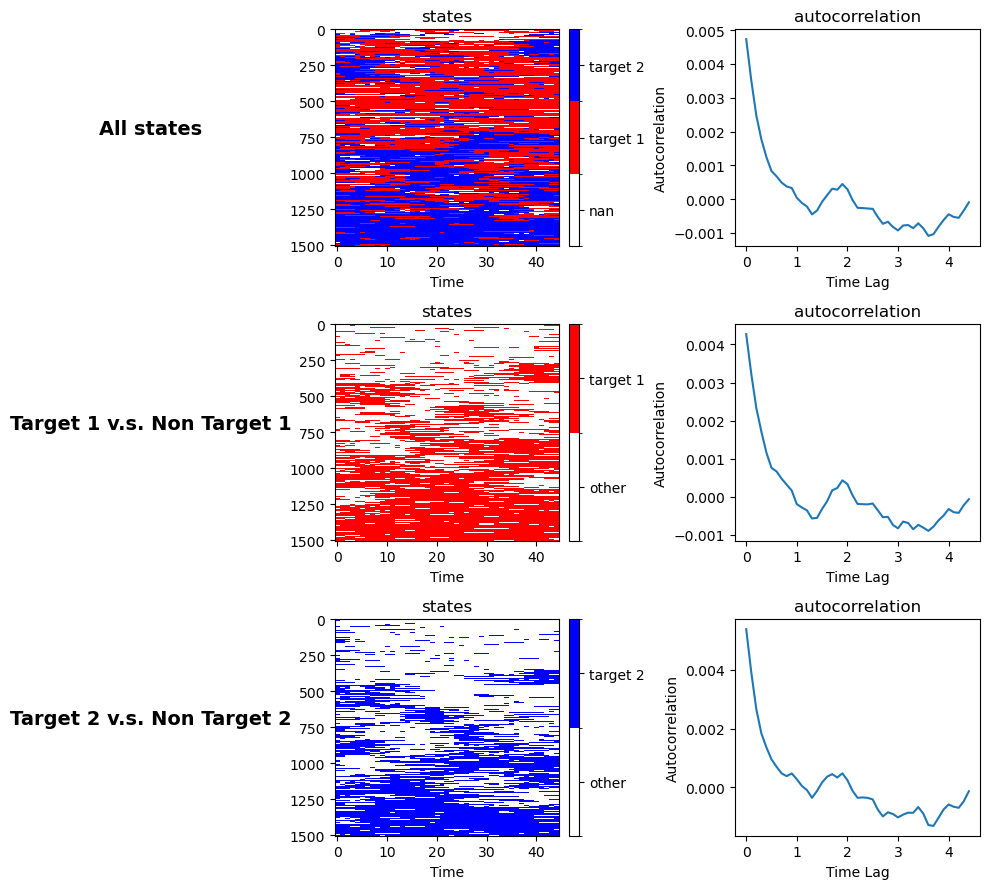

In [25]:
ft_analysis_results = summarize_oscillations_across_trials(
    test_times, confs[..., 0], confs[..., 1])

### Split draw and click

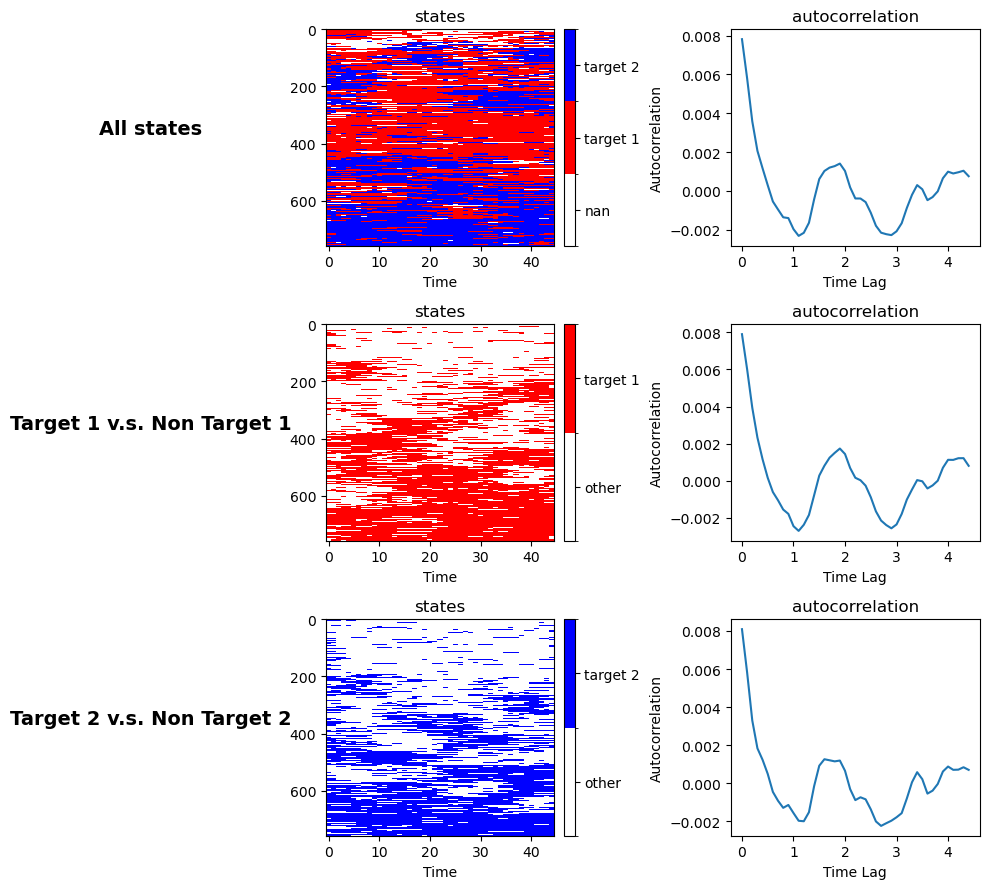

In [26]:
draw_mask = (behavior_df['mode'] == 'draw').to_numpy()
_ = summarize_oscillations_across_trials(
    test_times, confs[draw_mask][..., 0], confs[draw_mask][..., 1])

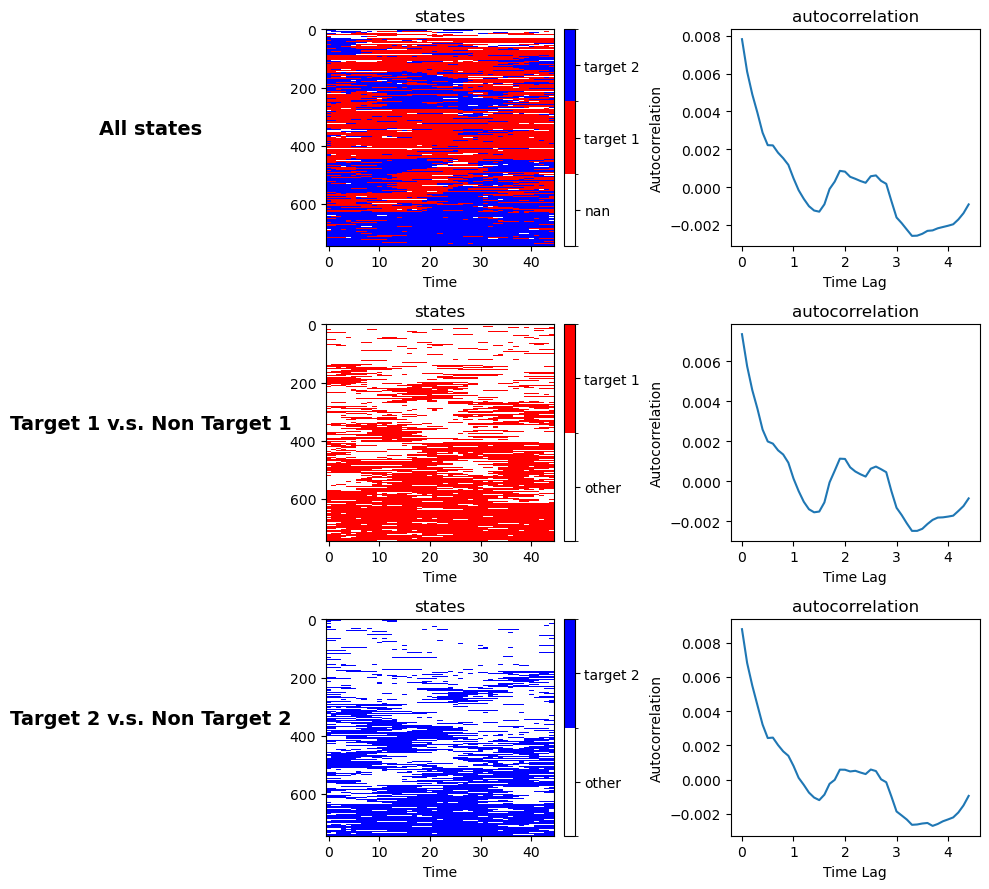

In [27]:
click_mask = (behavior_df['mode'] == 'click').to_numpy()
_ = summarize_oscillations_across_trials(
    test_times, confs[click_mask][..., 0], confs[click_mask][..., 1])